# Skew Correction

This google colab notebook introduces basic Document Image Processing Method called **Skew Correction**. 

Skew refers to the rotation of a document image from its intended orientation. This can happen during the scanning process and can affect the readability and usability of the document image.

---

Use the following drive link to access the images.

Drive Link: https://drive.google.com/drive/folders/1ivc4ISlTaUerNKcrMZUIb1yU-wkDZW-Y


## Mounting the google drive and loading requried libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode
import cv2
from google.colab.patches import cv2_imshow

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Skew Detection: 3 Steps

### Read Images

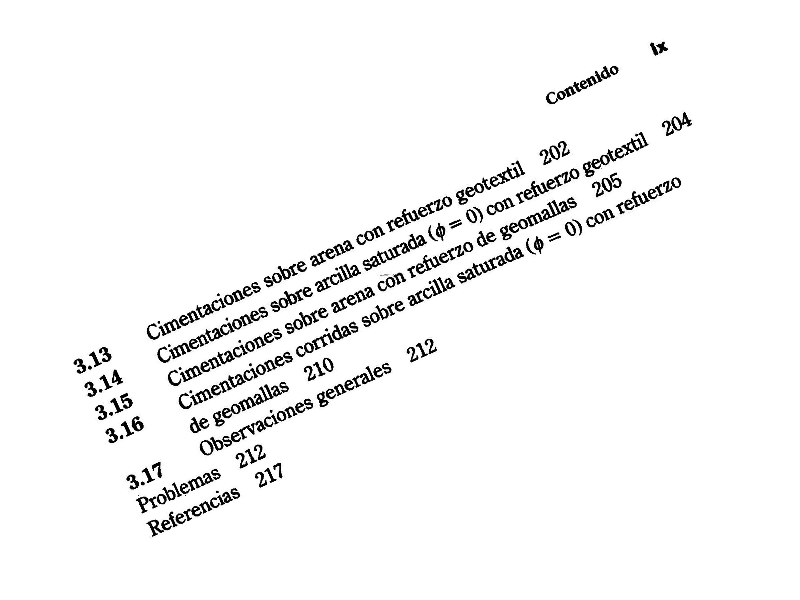

(600, 800, 3)

In [4]:
img_read = cv2.imread(f'/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/easy/1.png')
cv2_imshow(img_read)
img_read.shape

In [ ]:
#@title Solution
# reading Images 
path = '/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/easy/1.png'
image_easy  = imread(path)
cv2_imshow(image_easy)

### Convert to Grayscale

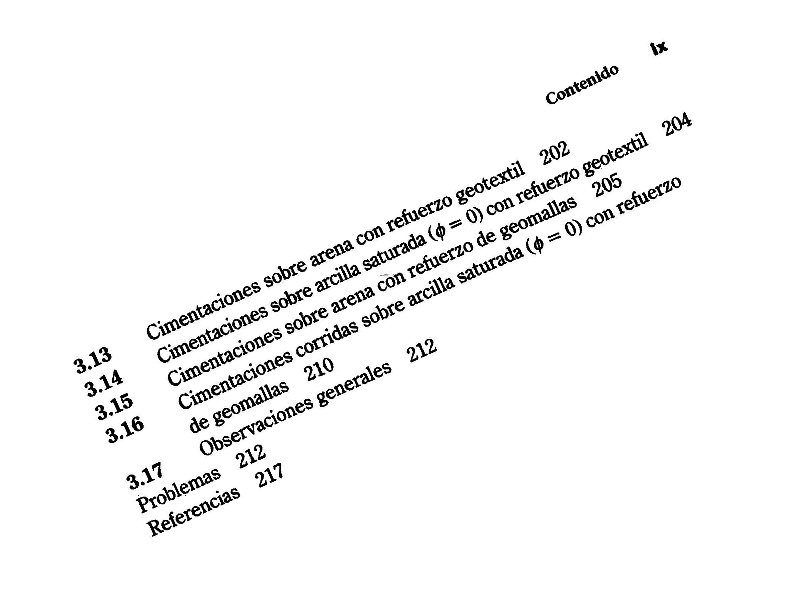

(600, 800)

In [5]:
img_gray = cv2.cvtColor(img_read, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)
img_gray.shape

In [ ]:
#@title Solution
gray_easy = rgb2gray(img_read[:,:,:3])
cv2_imshow(gray_easy)

Why the **3** in `image[:,:,:3]`?

#### It is a 3 channel image. We can verify that by priniting it's shape.

In [ ]:
#@title Solution
if len(image.shape)>2:
  gray = rgb2gray(image[:,:,:3])
else:
  gray = image

cv2_imshow(gray)

### Step-1: Edge Detection - `Canny` 

- Recall Yesterday's Sobel Filters!
- Canny Edge Detection is Similar with Extra Preprocessing and Refinement Steps like: Noise Reduction, Non-Maximal Supression, etc. 

Reference: 
1. https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html
2. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny


Function Signature: `canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False, *, mode='constant', cval=0.0)`

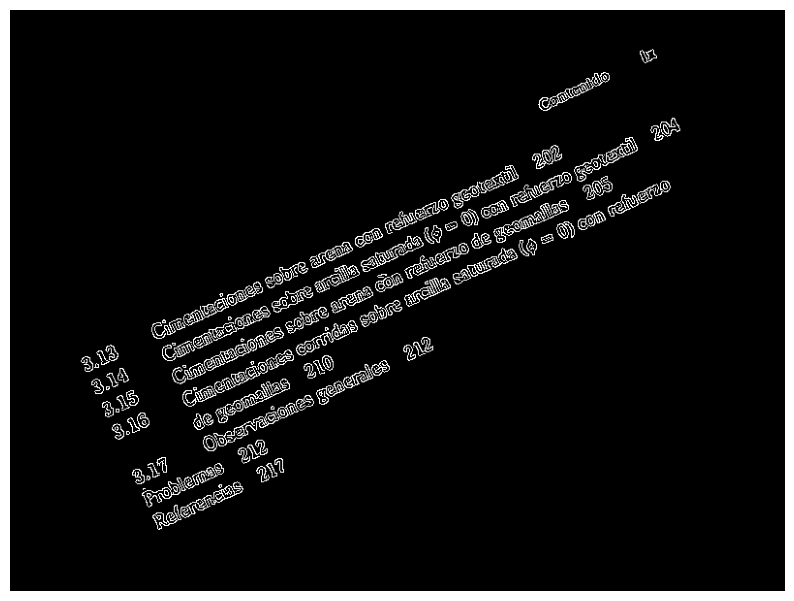

In [6]:
# edge detection
# Play with parameters like - increasing sigma value, etc.
img_edges = canny(img_gray, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False, mode='constant', cval=0.0)

#cv2_imshow(img_edges) # why this function doesn't work
# or
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(img_edges, cmap='gray')

In [ ]:
#@title Solution
# edge detection
edges_easy = canny(gray_easy)

plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(edges_easy, cmap='gray')

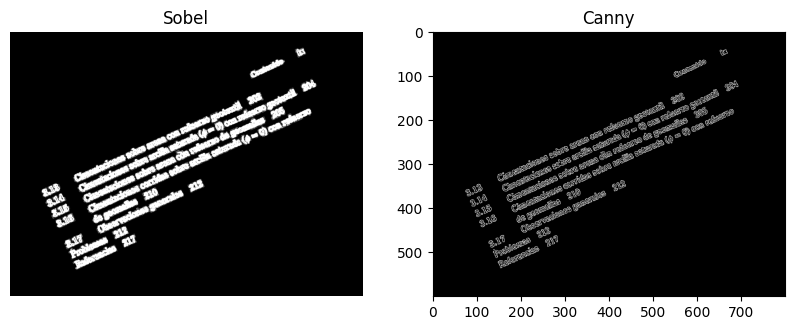

In [7]:
## Experiment with sobel and canny and observe the basic difference between canny and sobel in terms of their filter output

scale = 1
delta = 0
ddepth = cv2.CV_16S
gradX = cv2.Sobel(img_gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1) # experiment with ksize = 3
gradY = cv2.Sobel(img_gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1) # experiment with ksize = 3
gradient = cv2.sqrt(cv2.add(pow(gradX, 2), pow(gradY, 2))) # Compute the magnitue of gradients
gradient = cv2.convertScaleAbs(gradient) # Converts the output to an 8-bit representation
img_canny = canny(img_gray)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Sobel")
plt.imshow(gradient, cmap='gray')

plt.subplot(1,2,2)
plt.title("Canny")
plt.imshow(img_canny, cmap='gray')

# plt.tight_layout()
plt.show()

### Step-2: Line Detection - `Hough Transform`

Reference: https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

Define Range of Angles

In [8]:
# define range of angles
angles = np.deg2rad(np.arange(0.1, 180.0))
print(angles)
print('Count: ',len(angles))

[1.74532925e-03 1.91986218e-02 3.66519143e-02 5.41052068e-02
 7.15584993e-02 8.90117919e-02 1.06465084e-01 1.23918377e-01
 1.41371669e-01 1.58824962e-01 1.76278254e-01 1.93731547e-01
 2.11184839e-01 2.28638132e-01 2.46091425e-01 2.63544717e-01
 2.80998010e-01 2.98451302e-01 3.15904595e-01 3.33357887e-01
 3.50811180e-01 3.68264472e-01 3.85717765e-01 4.03171057e-01
 4.20624350e-01 4.38077642e-01 4.55530935e-01 4.72984227e-01
 4.90437520e-01 5.07890812e-01 5.25344105e-01 5.42797397e-01
 5.60250690e-01 5.77703982e-01 5.95157275e-01 6.12610567e-01
 6.30063860e-01 6.47517152e-01 6.64970445e-01 6.82423738e-01
 6.99877030e-01 7.17330323e-01 7.34783615e-01 7.52236908e-01
 7.69690200e-01 7.87143493e-01 8.04596785e-01 8.22050078e-01
 8.39503370e-01 8.56956663e-01 8.74409955e-01 8.91863248e-01
 9.09316540e-01 9.26769833e-01 9.44223125e-01 9.61676418e-01
 9.79129710e-01 9.96583003e-01 1.01403630e+00 1.03148959e+00
 1.04894288e+00 1.06639617e+00 1.08384947e+00 1.10130276e+00
 1.11875605e+00 1.136209

Use `hough_line(edges, theta=angles)` from skimage

Returns:
- `hspace`: is a 2D array that represents the Hough accumulator. The Hough accumulator is a data structure that is used to store the number of times each possible line is detected in the image.
- `theta`: is a 1D array that represents the angles of the detected lines. The angles are measured in radians.
- `distance`: is a 1D array that represents the distances of the detected lines from the origin. The distances are measured in pixels.

In [9]:
hspace, theta, d = hough_line(img_edges, theta=angles)

hough space 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


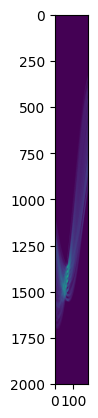

In [10]:
# Observe the peaks in the hough space, they represent the direction of dominant orientation
print("hough space \n", hspace)
plt.imshow(hspace)

In [11]:
# "theta" and "d" are the hough space represenations of line equations
print("theta", theta)
print("d", d)

theta [1.74532925e-03 1.91986218e-02 3.66519143e-02 5.41052068e-02
 7.15584993e-02 8.90117919e-02 1.06465084e-01 1.23918377e-01
 1.41371669e-01 1.58824962e-01 1.76278254e-01 1.93731547e-01
 2.11184839e-01 2.28638132e-01 2.46091425e-01 2.63544717e-01
 2.80998010e-01 2.98451302e-01 3.15904595e-01 3.33357887e-01
 3.50811180e-01 3.68264472e-01 3.85717765e-01 4.03171057e-01
 4.20624350e-01 4.38077642e-01 4.55530935e-01 4.72984227e-01
 4.90437520e-01 5.07890812e-01 5.25344105e-01 5.42797397e-01
 5.60250690e-01 5.77703982e-01 5.95157275e-01 6.12610567e-01
 6.30063860e-01 6.47517152e-01 6.64970445e-01 6.82423738e-01
 6.99877030e-01 7.17330323e-01 7.34783615e-01 7.52236908e-01
 7.69690200e-01 7.87143493e-01 8.04596785e-01 8.22050078e-01
 8.39503370e-01 8.56956663e-01 8.74409955e-01 8.91863248e-01
 9.09316540e-01 9.26769833e-01 9.44223125e-01 9.61676418e-01
 9.79129710e-01 9.96583003e-01 1.01403630e+00 1.03148959e+00
 1.04894288e+00 1.06639617e+00 1.08384947e+00 1.10130276e+00
 1.11875605e+00 1.

**Get Prominent Lines**: `hough_line_peaks`

Function Signature: `hough_line_peaks(hspace, angles, dists, min_distance=9, min_angle=10, threshold=None, num_peaks=inf)`

- Most prominent lines separated by a certain angle and distance in a Hough transform.
- Performs [Non-maximum Suppression](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) to identify Peaks

In [12]:
# find location of the line peaks and angles in hough space
accum, angles, dists = hough_line_peaks(hspace, theta, d)
accum.shape

(7,)

Size of "accum" represents the number of lines/peaks detected by the algorithm.

In [13]:
list(zip(*hough_line_peaks(hspace, theta, d)))

[(245, 1.1536626355682518, 446.0),
 (236, 1.1536626355682518, 391.0),
 (219, 1.1362093430483085, 424.0),
 (203, 1.1362093430483085, 373.0),
 (163, 0.9791297103688189, 474.0),
 (138, 0.9267698328089891, 496.0),
 (135, 0.7696902001294994, 484.0)]

In [14]:
hspace.max()

245

##### Visualize Detected Lines

Text(0.5, 1.0, 'Detected lines')

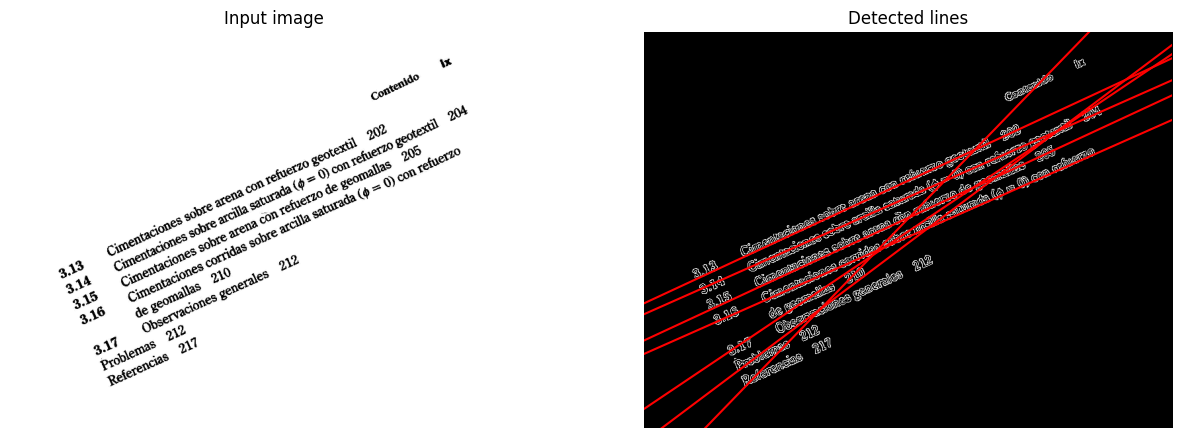

In [15]:
# Generating Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img_gray, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(img_edges, cmap="gray")
origin = np.array((0, img_read.shape[1]))

# plot lines
for _, angle, dist in zip(*hough_line_peaks(hspace, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    
ax[1].set_xlim(origin)
ax[1].set_ylim((img_edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

In [16]:
# Try Faster Houghline!
lines = probabilistic_hough_line(img_edges, threshold=10, line_length=5, line_gap=3)

### Step-3: Domninant Angle - Most Common Angle

##### Visualize Hough Space

(-0.4, 179.6, 1000.5, -1000.5)

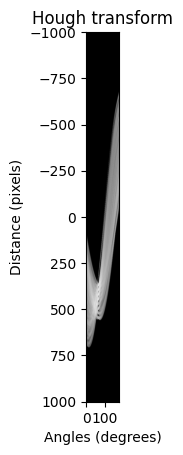

In [17]:
# Visualize Hough Space

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.imshow(np.log(1 + hspace), extent=bounds, cmap='gray', aspect=1 / 1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.axis('image')

##### Mode - Common

In [18]:
# round the angles to 2 decimal places and find the most common angle.
dominant_angle = mode(np.around(angles, decimals=3), keepdims=False)[0]
dominant_angle

1.136

In [19]:
# convert the angle to degree for rotation.
skew_angle = np.rad2deg(dominant_angle - np.pi/2)
skew_angle

-24.91199447313849

Why did we subtract $\frac{Π}{2}$?

Try without Subtracting!

In [20]:
new_skew_angle = np.rad2deg(dominant_angle)
new_skew_angle

65.08800552686151

## 2. Skew Correction: Rotate the image to deskew it

### Finaly There!! Get the rotated Image Back! Easy

![](https://media.tenor.com/PriVq8YusysAAAAM/yeah-but-how-stan-marsh.gif)


### Apply Affine Transform!

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--_L7TDW3Y--/c_imagga_scale,f_auto,fl_progressive,h_900,q_auto,w_1600/https://dev-to-uploads.s3.amazonaws.com/i/yhc6kp16j6bi5ddtfn88.png" alt= “Affine” width="60%" height="value">

What is an Affine Transformation?
- A transformation: a matrix multiplication (linear transformation) followed by a vector addition (translation).
- Parallel Line remain parallel after Transform

We can express following with Affone:
- Rotations (linear transformation)
- Translations (vector addition)
- Scale operations (linear transformation)

Resource: https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

How do we rotate?
$$
R = \begin{bmatrix}
α & β & (1−α)⋅center.x−β⋅center.y \\
-β & α & β⋅center.x+(1−α)⋅center.y
\end{bmatrix}
$$
![](https://i.imgflip.com/11dmtp.jpg)
![opencv](./7mr495.jpg)

Function: `cv2.getRotationMatrix2D(center, angle, scale)`

Paramters:
- `center`:	Center of the rotation in the source image.
- `angle`:	Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
- `scale`:	Isotropic scale factor.

Find Centre

In [21]:
# find center
(h, w) = img_read.shape[:2]
center = (w // 2, h // 2)
center

(400, 300)

Get Rotation Matrix, $R$

Reference: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326

In [22]:
R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
R

array([[   0.90695585,   -0.42122569,  163.58536485],
       [   0.42122569,    0.90695585, -140.57703105]])

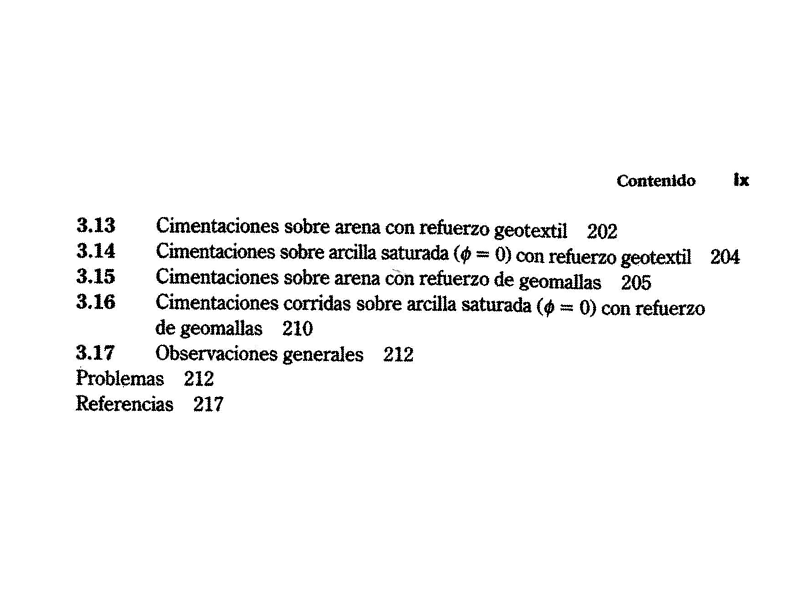

In [23]:
rotated = cv2.warpAffine(img_read, R, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotated)

Another Way!

Rotate Fn Signature: `rotate(image, angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)`

Reference: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rotate

In [24]:
rotated_faulty = rotate(img_read, skew_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)

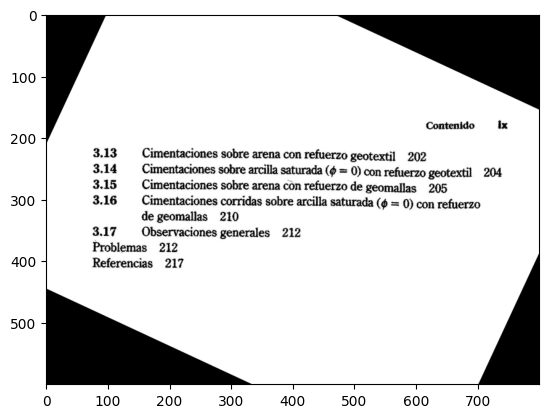

In [25]:
plt.imshow(rotated_faulty, cmap='gray')

Issues:
1. Colour: Black Region
2. Boundaries

Fix it!

#### Skew Correction: Final Function 

In [26]:
def plot_images(image, rotated):
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(rotated, cmap="gray")
  ax[1].set_axis_off()
  ax[1].set_title('Skew Corrected')

  return

def show_detected_lines(image, edges, lines):
  # Generating Plots
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  
  # fig.suptitle('Intermediate Lines')
  
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(edges, cmap="gray")
  origin = np.array((0, image.shape[1]))

  # plot lines
  for _, angle, dist in lines:
      y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
      ax[1].plot(origin, (y0, y1), '-r')
      
  ax[1].set_xlim(origin)
  ax[1].set_ylim((edges.shape[0], 0))
  ax[1].set_axis_off()
  ax[1].set_title('Detected lines')

  return

In [27]:
#@title Final Algorithm

# skew detecttion
def detect_skew(image:np.ndarray, show_interm=False)->float:
  # convert to edges
  edges = canny(image)
  # Classic straight-line Hough transform between 0.1 - 180 degrees.
  angles = np.deg2rad(np.arange(0.1, 180.0))
  h, theta, d = hough_line(edges, theta=angles)
  
  # find line peaks and angles
  accum, angles, dists = hough_line_peaks(h, theta, d)
  lines = zip(accum, angles, dists)

  if show_interm:
    show_detected_lines(image, edges, lines)
  
  # round the angles to 3 decimal places and find the most common angle.
  dominant_angle = mode(np.around(angles, decimals=3), keepdims=False)[0]
  
  # convert the angle to degree for rotation.
  skew_angle = np.rad2deg(dominant_angle - np.pi/2)

  return skew_angle

def preprocessing(image:np.ndarray, noprep=True):
  if len(image.shape)>2:
    image = rgb2gray(image[:,:,:3])

  if not noprep:
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply image denoising
    denoised = cv2.fastNlMeansDenoising(blur, None, h=10, templateWindowSize=7, searchWindowSize=21)
      
    # Apply binary thresholding
    _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY)

    return binary
  else:
    return image

def preprocessing_noise(image:np.ndarray, noprep=True):
    if len(image.shape): #gray
      blur = cv2.GaussianBlur(image, (5, 5), 0)
      # Apply image denoising
      denoised = cv2.fastNlMeansDenoising(blur, None, 10, 10)
      median = cv2.medianBlur(denoised, 5)
    
      # Apply binary thresholding
      _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY)
      return binary
    else:
      print("ERROR")
      1/0

# rotate Image
def deSkew(image:np.ndarray, skew_angle:float)->np.ndarray:
  '''rotate the image to deskew it'''
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  
  R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
  rotated = cv2.warpAffine(image, R, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

  return rotated

def post_processing(rotated: np.ndarray)->np.ndarray:
  # Hint: The images don't look crisp!
  pass
  return rotated

def SkewCorrection(path, verbose=False, noprep=True):
  # read Image
  image = imread(path)

  image_pre = preprocessing(image, noprep)

  if not noprep:  
    plt.title('After Preprocessing')
    plt.imshow(image_pre, cmap='gray')

  # determine angle
  skew_angle = detect_skew(image_pre, verbose)

  # print('\n\n\n')

  # if verbose:
  #   print(f'Skew Angle is {skew_angle:.3f}')
  
  # if skew_angle < -45:
  #   skew_angle = -(90 + skew_angle)
  # # otherwise, just take the inverse of the angle to make
  # # it positive
  # else:
  #   skew_angle = skew_angle
  
  if verbose:
    print(f'Skew Angle is {skew_angle:.3f}')

  # Rotate Image
  rotated = deSkew(image, skew_angle)

  # post processing!
  rotated_final = post_processing(rotated)
  
  print('\n\n\n')
  
  # plot images
  plot_images(image, rotated_final)

  return rotated_final

def SkewCorrectionWithNoise(path, verbose=False, noprep=True):
  # read Image
  image = imread(path)

  image_pre = preprocessing_noise(image, noprep)

  if not noprep:  
    plt.title('After Preprocessing')
    plt.imshow(image_pre, cmap='gray')

  # determine angle
  skew_angle = detect_skew(image_pre, verbose)

  # print('\n\n\n')

  # if verbose:
  #   print(f'Skew Angle is {skew_angle:.3f}')
  
  # if skew_angle < -45:
  #   skew_angle = -(90 + skew_angle)
  # # otherwise, just take the inverse of the angle to make
  # # it positive
  # else:
  #   skew_angle = skew_angle
  
  if verbose:
    print(f'Skew Angle is {skew_angle:.3f}')

  # Rotate Image
  rotated = deSkew(image, skew_angle)

  # post processing!
  rotated_final = post_processing(rotated)
  
  print('\n\n\n')
  
  # plot images
  plot_images(image, rotated_final)

  return rotated_final

Skew Angle is -24.912






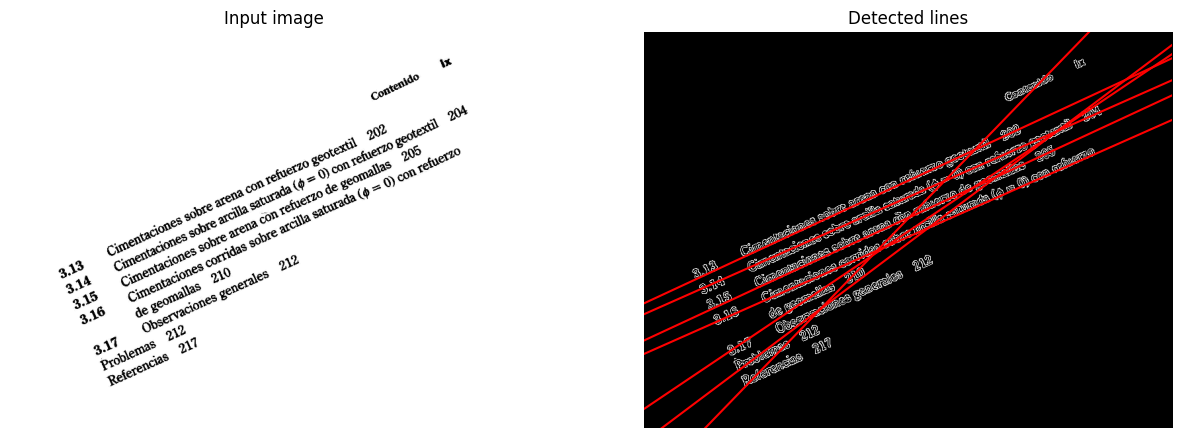

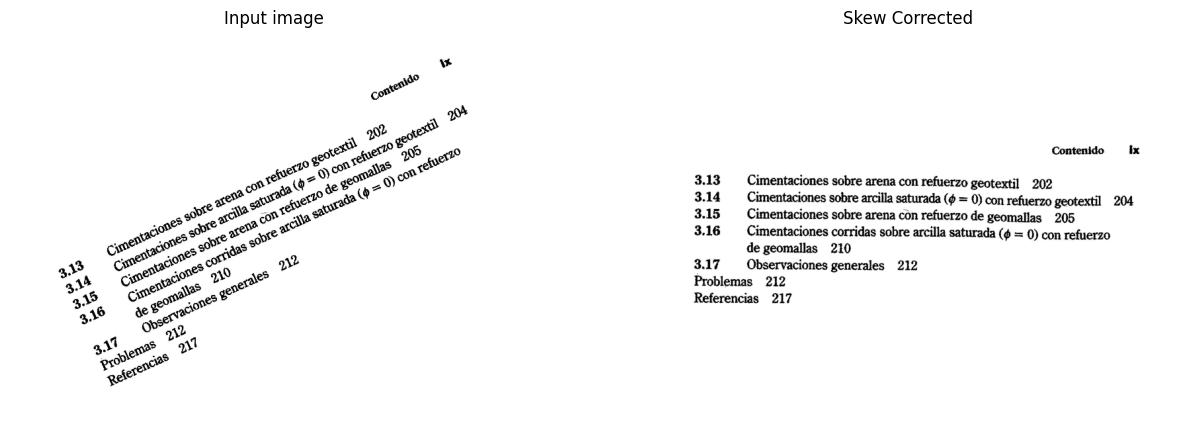

In [28]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/easy/1.png', verbose=True)

Skew Angle is -22.907






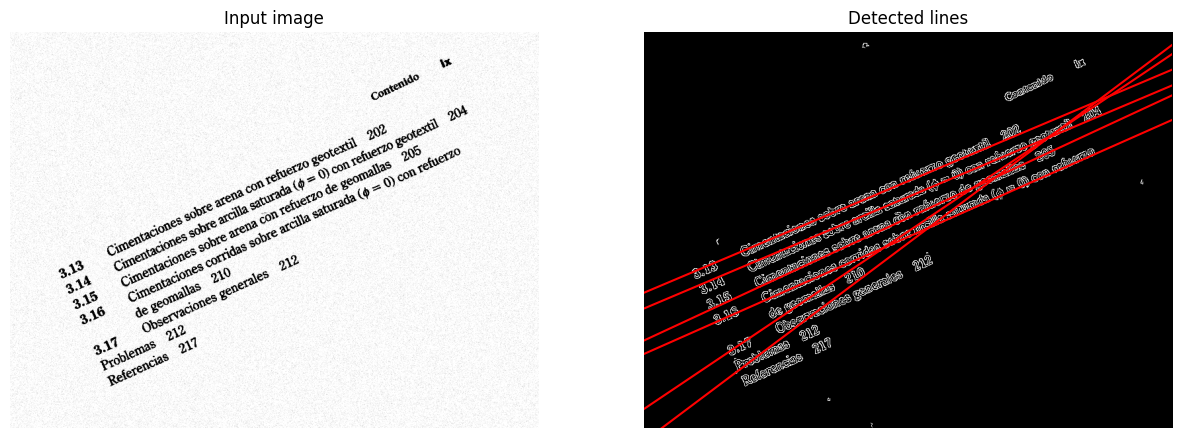

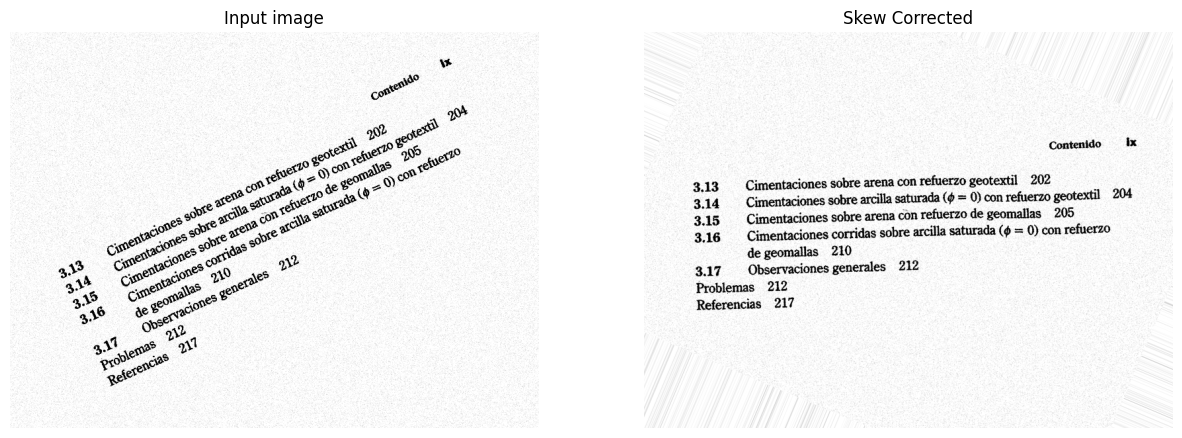

In [29]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/med/1_pn.png', verbose=True)

In [30]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/tough/1_gn.png', verbose=True)

Output hidden; open in https://colab.research.google.com to view.

Skew Angle is 0.126






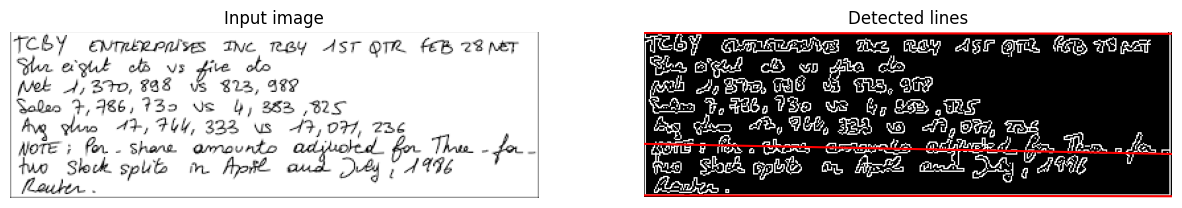

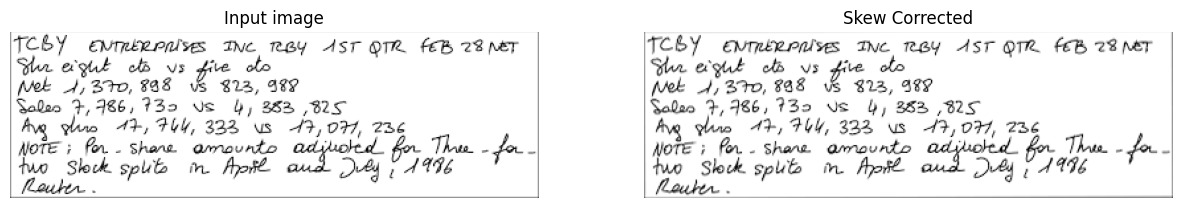

In [31]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/easy/9.png', verbose=True)

Skew Angle is -39.923






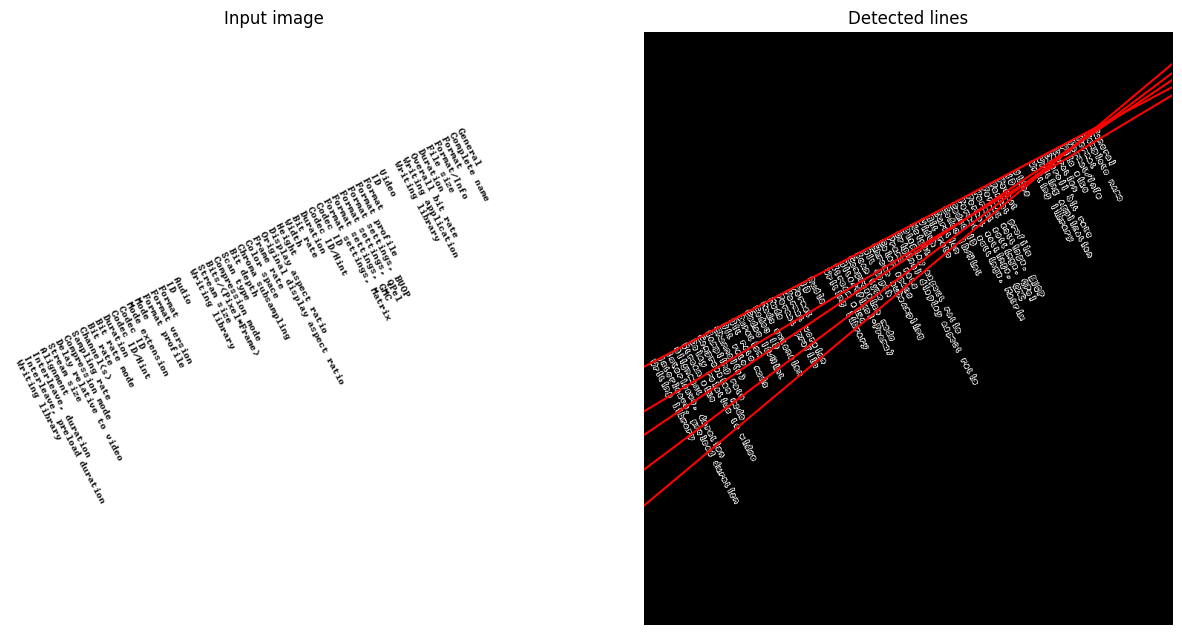

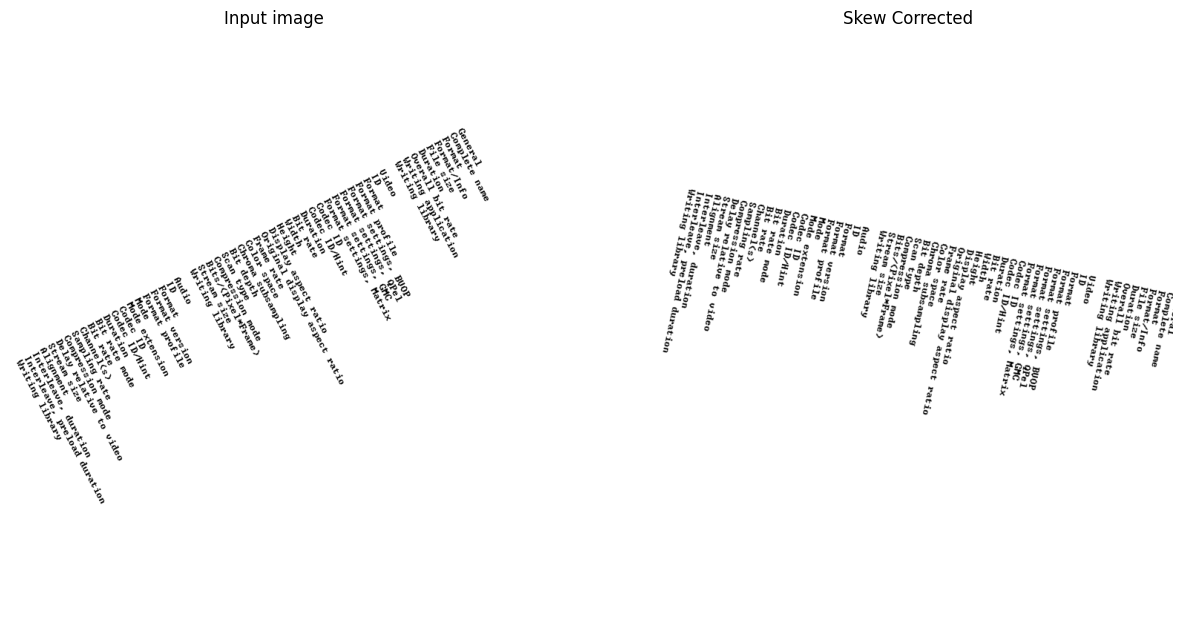

In [32]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/tough/5.png', verbose=True)

Skew Angle is -38.892






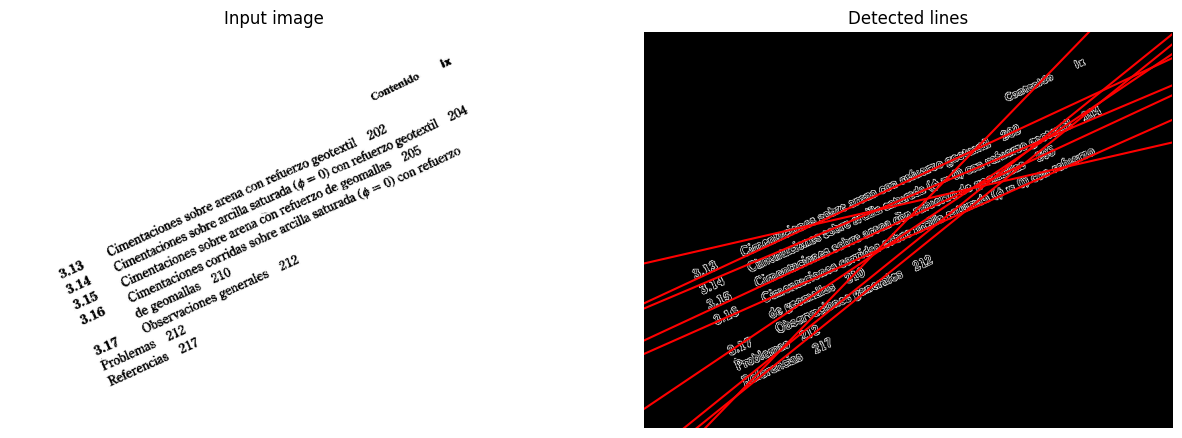

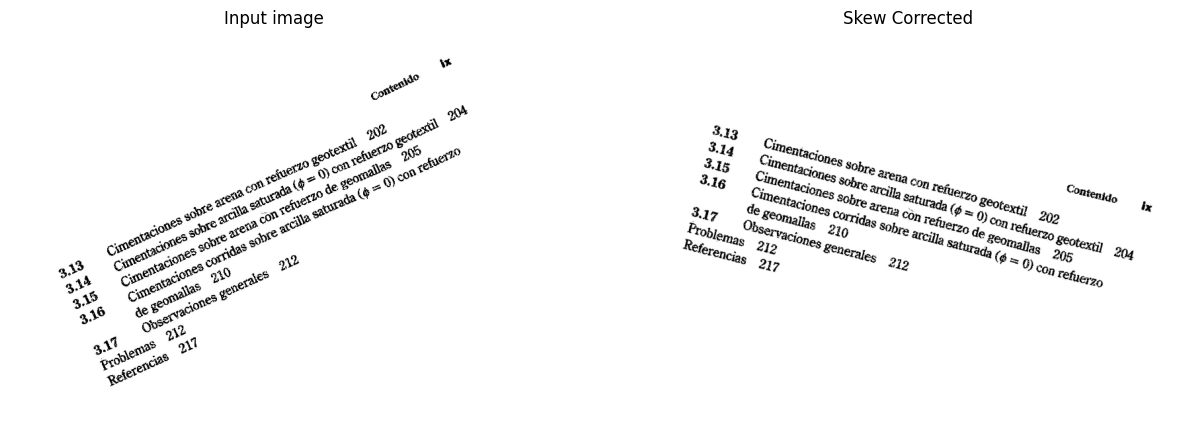

In [33]:
deSkewed_img = SkewCorrection('/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/med/1_s.png', verbose=True)

There is no One-size-fits-all solution!!
- Possible solutions: Compute the minimum rotated bounding Bounding Rectangle.

### Observations:

Our line detection algorithm does not seem to be working on some images because of the various types of noise present in the image, like gaussian, salt-and-pepper, etc. Therefore, a very important step in image pre-processing is removal of noise and then application of the algorithm.

Without Noise Removal and with Noise Removal 

In [34]:
noisy_img = '/content/drive/MyDrive/CVIT/orientation_22may/Day2/images/skew/med/1_s.png'

Without Noise Removal:

Skew Angle is -38.892






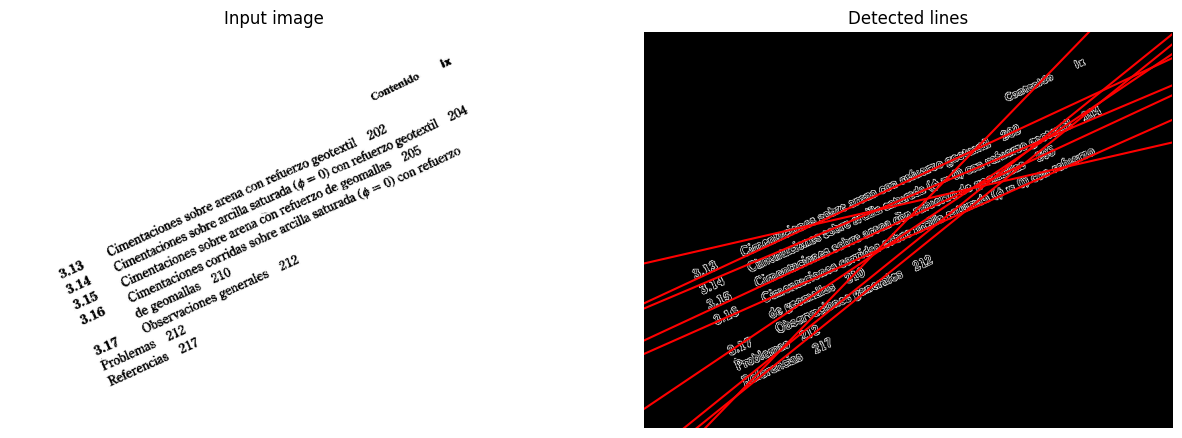

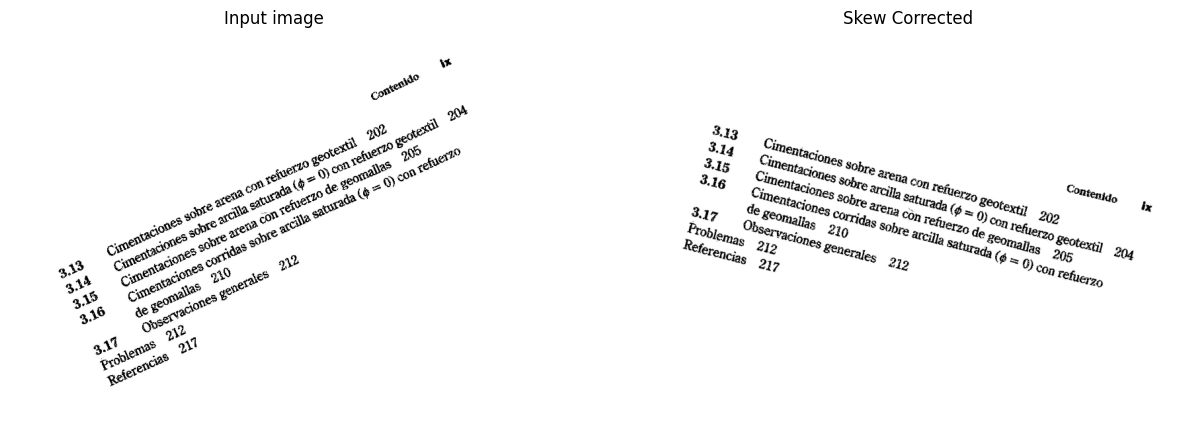

In [48]:
deSkewed_img = SkewCorrection(noisy_img, verbose=True)

With Noise Removal

Skew Angle is -24.912






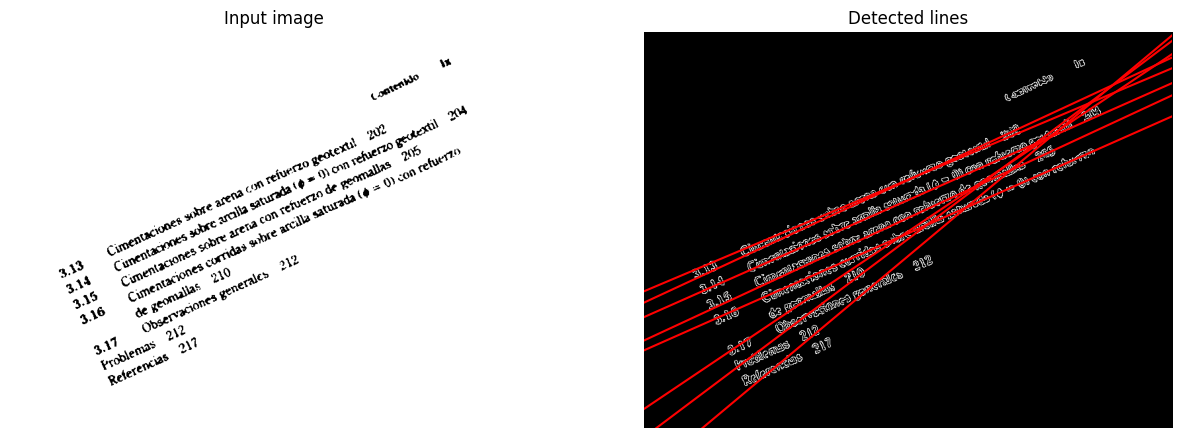

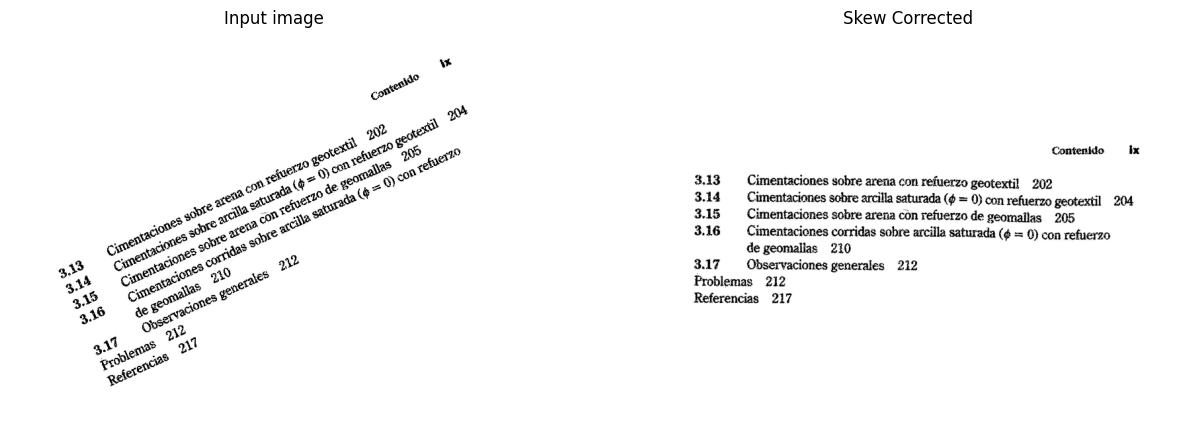

In [35]:
deSkewed_img = SkewCorrectionWithNoise(noisy_img, verbose=True)

As we can see, with the help of noise removal filters, we are able to correct the skew eventually.

----